### Accepted & Rejected Loan Applications

**Objective**:  
We have been hired by lending club and are tasked with a few objectives. First, we are interested in building a model to classify a loan to as accepted or rejected. Once we automated that process, the next steps will be to build multiple models to predict the grade of the loans, the sub-grades, and the interest rates. During our initial cleaning (see cleaning notebook), we took care various steps handling preprocessing and missing values. This notebook will be dedicated to understanding which factors play a role in a loan being accepted/rejected and building a model to predict that.

**Imports**

In [105]:
import os

os.chdir(os.path.join(os.getcwd(), '..'))

import json
import logging
import re
import string
from collections import Counter

import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from nltk.corpus import stopwords
from joblib import dump
from optuna.visualization import plot_optimization_history
from scipy.stats import pointbiserialr
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (average_precision_score, auc,
                             classification_report, confusion_matrix,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     cross_val_predict, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import optuna
from tqdm import tqdm

from project_utils.functions import (
    apply_minibatch_kmeans, apply_tfidf_vectorizer, confusion_matrix_df,
    create_pipeline, create_preprocessor, extract_feature_importances,
    mutual_information_scores, null_percentages, preprocess_text,
    multiple_test_chi2, mutiple_test_mann_whitney,
    get_numerical_categorical_columns)
from plot_utils import annotate_bars, hide_spines, plot_model_evaluation
from project_utils.objective_functions import get_objective_xgb_binary

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
plt.style.use('deeplearning.mplstyle')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_blue = default_colors[0]

In [5]:
df_accepted = pd.read_csv('lending_club_data/accepted_cleaned.csv',
                          dtype={'zip_code': str},
                          low_memory=False)
df_rejected = pd.read_csv('lending_club_data/rejected_cleaned.csv',
                          dtype={'zip_code': str},
                          low_memory=False)

In [6]:
# Down casting float 64 --> 32
float_types_accepted = df_accepted.select_dtypes(exclude='object').columns
float_types_rejected = df_rejected.select_dtypes(exclude='object').columns

df_accepted[float_types_accepted] = df_accepted[float_types_accepted].apply(
    lambda x: x.astype(np.float32))
df_rejected[float_types_rejected] = df_rejected[float_types_rejected].apply(
    lambda x: x.astype(np.float32))

**What features do our accepted and rejected datasets share?**

In [8]:
df_accepted['average_fico_score'] = (df_accepted['fico_range_high'] +
                                     df_accepted['fico_range_low']) / 2

In [9]:
df_rejected['average_fico_score'] = df_rejected['risk_score']

In [11]:
df_accepted_subset = df_accepted[[
    'loan_amnt', 'purpose', 'dti', 'addr_state', 'zip_code', 'emp_length',
    'average_fico_score'
]]
df_rejected_subset = df_rejected[[
    'amount_requested', 'loan_title', 'debt_to_income_ratio', 'state',
    'zip_code', 'employment_length', 'average_fico_score'
]].rename(columns={'loan_title': 'purpose'})

df_accepted_subset.loc[:, 'accepted'] = 1
df_rejected_subset.loc[:, 'accepted'] = 0

In [12]:
# Unify column names
df_rejected_subset.columns = df_accepted_subset.columns

In [13]:
df_accepted_rejected = pd.concat([df_accepted_subset, df_rejected_subset],
                                 axis=0,
                                 ignore_index=True)

In [15]:
df_accepted_rejected.shape

(29751456, 8)

**Distribution of Accepted/Rejected Loans**

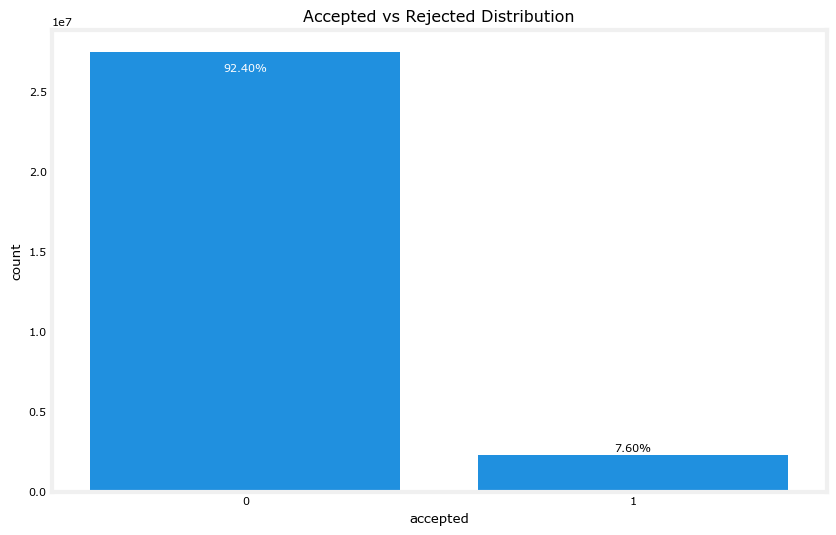

In [16]:
plt.figure(figsize=(10, 6))
plt.title("Accepted vs Rejected Distribution")
fig = sns.countplot(df_accepted_rejected, x='accepted', color=default_blue)
annotate_bars(fig, percentage=True)
plt.show()

- Our distribution of accepted vs. rejected displays a clear imbalance of classes, where approximately 93% of our instances belong to rejected and 7% belong to accepted. This is something we will be taking care of during preprocessing, testing out different sampling methods, and evaluating our model.

**Does the amount requested impact the acceptance or rejection of a loan?**

In [14]:
print(
    f"Accepted amount requested {df_accepted_subset['amount_requested'].describe()}"
)
print(
    '------------------------------------------------------------------------------'
)
print(
    f"Rejected amount requested {df_rejected_subset['amount_requested'].describe()}"
)

Accepted amount requested count    2.260668e+06
mean     1.504693e+04
std      9.190245e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.290000e+04
75%      2.000000e+04
max      4.000000e+04
Name: amount_requested, dtype: float64
------------------------------------------------------------------------------
Rejected amount requested count    2.749079e+07
mean     1.310414e+04
std      1.488779e+04
min      0.000000e+00
25%      4.700000e+03
50%      1.000000e+04
75%      2.000000e+04
max      1.400000e+06
Name: amount_requested, dtype: float64


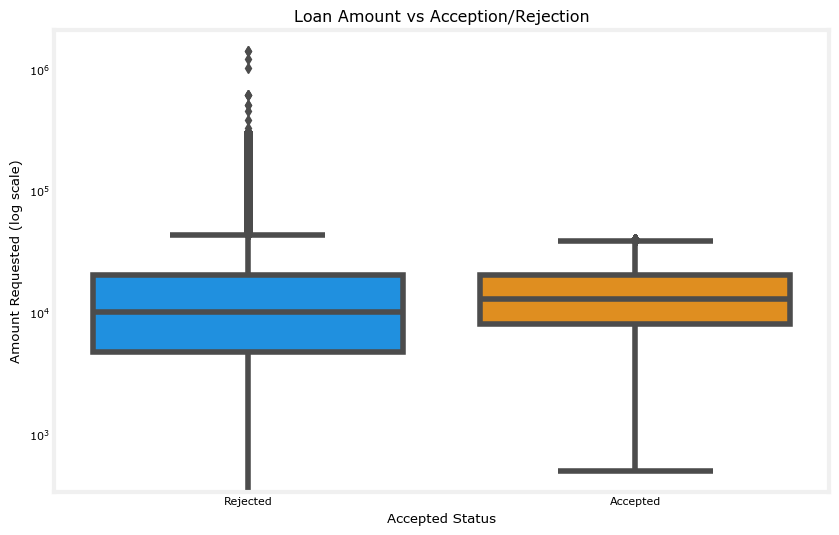

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='accepted', y='loan_amnt', data=df_accepted_rejected)
plt.yscale('log')
plt.title('Loan Amount vs Acception/Rejection')
plt.xlabel('Accepted Status')
plt.ylabel('Amount Requested (log scale)')
plt.xticks([0, 1], ['Rejected', 'Accepted'])
plt.show()

In [18]:
df_accepted_subset['loan_amnt'].sort_values(ascending=False).head()

587567     40000.0
1602223    40000.0
1602214    40000.0
2099327    40000.0
824727     40000.0
Name: loan_amnt, dtype: float32

In [19]:
df_accepted_rejected_cleaned = df_accepted_rejected[
    (df_accepted_rejected['loan_amnt'] <= 40000)
    & (df_accepted_rejected['loan_amnt'] > 100)]

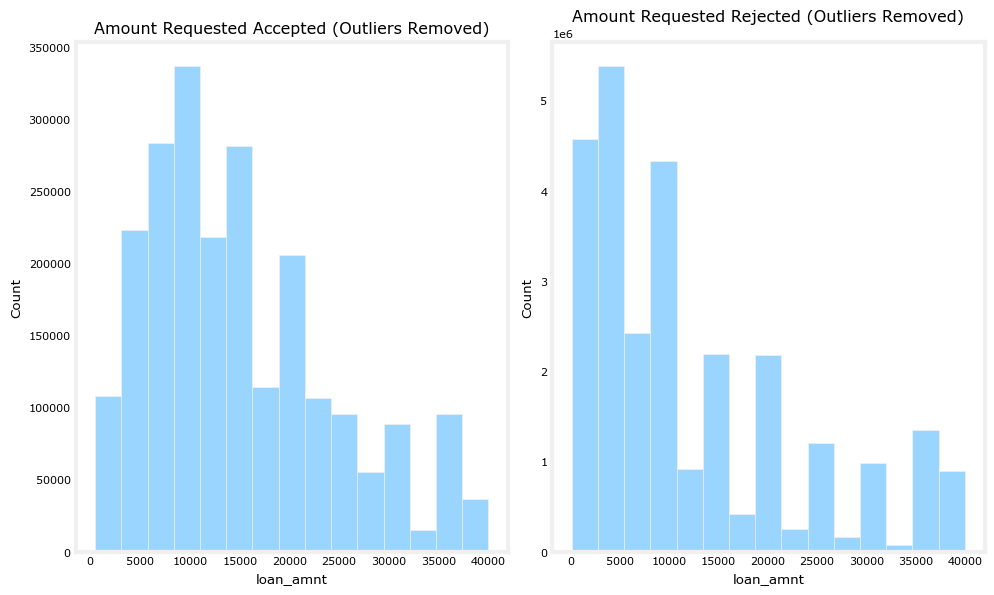

In [20]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Amount Requested Accepted (Outliers Removed)')
sns.histplot(df_accepted_rejected_cleaned[
    df_accepted_rejected_cleaned['accepted'] == 1],
             x='loan_amnt',
             bins=15,
             alpha=0.4)
plt.subplot(1, 2, 2)
plt.title('Amount Requested Rejected (Outliers Removed)')
sns.histplot(df_accepted_rejected_cleaned[
    df_accepted_rejected_cleaned['accepted'] == 0],
             x='loan_amnt',
             bins=15,
             alpha=0.4)
plt.tight_layout()
plt.show()

- After doing some research on the lending club website, we discovered that the largest loan a person can take out is forty thousand dollars. Confirming our beliefs, we also identified that the maximum value in the accepted data frame is forty thousand dollars. Taking a look at our distributions, we can see that the rejected applicants contain a significant amount of outliers (173k), indicating that many people applied for loans well above the lending club limit, thus leading to rejection. Therefore, we will be removing these data points as they won't add any value to our model considering that 40k is the maximum.

**Does debt to income ratio impact the acceptance or rejection of a loan?**

In [22]:
print('Accepted DTI')
print(df_accepted_subset['dti'].describe())
print('------------------------------------------------------')
print('Rejected DTI')
print(df_rejected_subset['dti'].describe())

Accepted DTI
count    2.258957e+06
mean     1.882419e+01
std      1.418333e+01
min     -1.000000e+00
25%      1.189000e+01
50%      1.784000e+01
75%      2.449000e+01
max      9.990000e+02
Name: dti, dtype: float64
------------------------------------------------------
Rejected DTI
count    2.749079e+07
mean     1.434146e+02
std      1.056667e+04
min     -1.000000e+00
25%      8.100000e+00
50%      1.998000e+01
75%      3.653000e+01
max      5.000003e+07
Name: dti, dtype: float64


In [23]:
df_accepted_rejected_cleaned[(df_accepted_rejected_cleaned['dti'] < 0) |
                             (df_accepted_rejected_cleaned['dti'] >= 50)].shape

(4986864, 8)

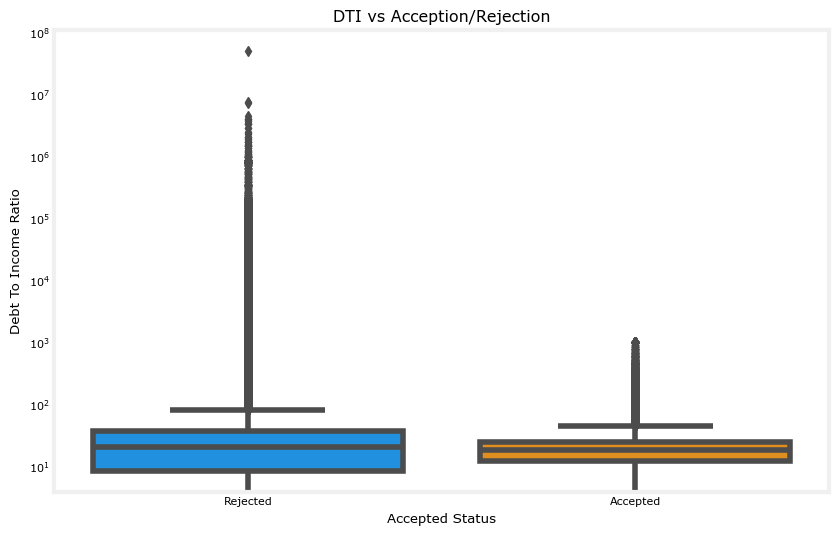

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='accepted', y='dti', data=df_accepted_rejected_cleaned)
plt.title('DTI vs Acception/Rejection')
plt.xlabel('Accepted Status')
plt.ylabel('Debt To Income Ratio')
plt.yscale('log')
plt.xticks([0, 1], ['Rejected', 'Accepted'])
plt.show()

In [25]:
df_accepted_rejected_cleaned = df_accepted_rejected_cleaned[
    (df_accepted_rejected_cleaned['dti'] > 0)
    & (df_accepted_rejected_cleaned['dti'] <= 50)]

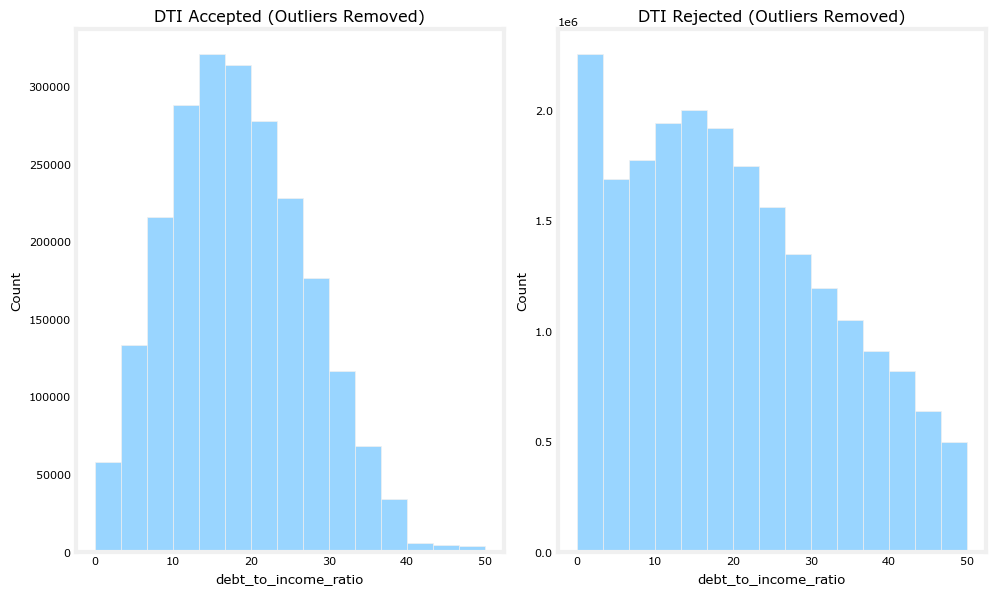

In [26]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('DTI Accepted (Outliers Removed)')
sns.histplot(df_accepted_rejected_cleaned[
    df_accepted_rejected_cleaned['accepted'] == 1],
             x='dti',
             bins=15,
             alpha=0.4)
plt.subplot(1, 2, 2)
plt.title('DTI Rejected (Outliers Removed)')
sns.histplot(df_accepted_rejected_cleaned[
    df_accepted_rejected_cleaned['accepted'] == 0],
             x='dti',
             bins=15,
             alpha=0.4)
plt.tight_layout()
plt.show()

- After investigating our debt-to-income ratio column, we concluded a few things. First, there were quite a few outliers that had a negative debt-to-income ratio (-1), which could possibly represent not being filled in; it was not clear in the data dictionary or from the data source. We also observed debt-to-income values that were very extreme (> 100). After researching on the lending club website and other various sources, they stated that the usually maximum dti a lender would accept is 40%, with some exceptions in the 50%. Therefore, we will be capping at 50%.

**Does the unified credit score impact the acceptance/rejection of a loan?**

In [26]:
print('Accepted Credit Score')
print(df_accepted_subset['average_fico_score'].describe())
print('------------------------------------------------------')
print('Rejected Credit Score')
print(df_rejected_subset['average_fico_score'].describe())

Accepted Credit Score
count    2.260668e+06
mean     7.005884e+02
std      3.301081e+01
min      6.120000e+02
25%      6.770000e+02
50%      6.920000e+02
75%      7.170000e+02
max      8.475000e+02
Name: average_fico_score, dtype: float64
------------------------------------------------------
Rejected Credit Score
count    9.130929e+06
mean     6.281711e+02
std      8.980838e+01
min      0.000000e+00
25%      5.910000e+02
50%      6.370000e+02
75%      6.750000e+02
max      9.900000e+02
Name: average_fico_score, dtype: float64


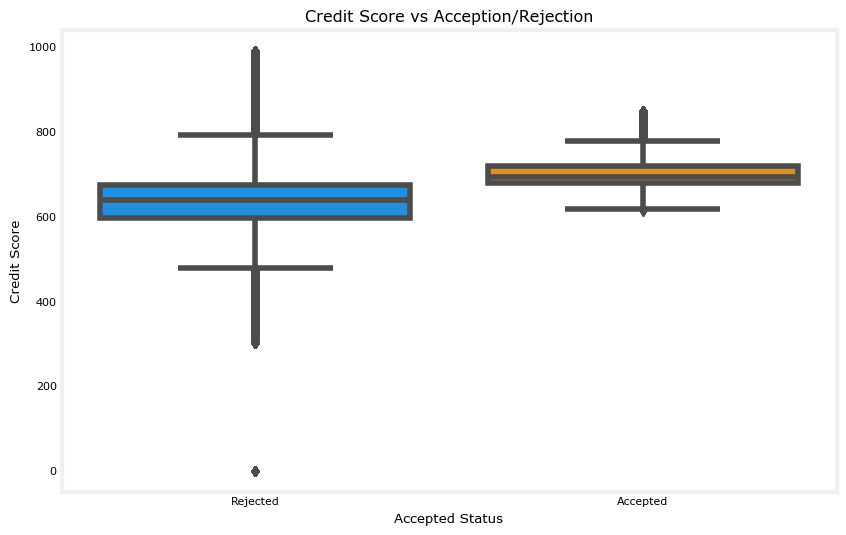

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='accepted',
            y='average_fico_score',
            data=df_accepted_rejected_cleaned)
plt.title('Credit Score vs Acception/Rejection')
plt.xlabel('Accepted Status')
plt.ylabel('Credit Score')
plt.xticks([0, 1], ['Rejected', 'Accepted'])
plt.show()

In [29]:
df_accepted_rejected_cleaned[df_accepted_rejected_cleaned['average_fico_score']
                             < 100].shape

(14426, 8)

In [94]:
null_percentages(df_accepted_rejected_cleaned)

amount_requested         0.000000
purpose                  0.045501
debt_to_income_ratio     0.000000
state                    0.000000
zip_code                 0.000008
employment_length        3.743907
unified_credit_score    58.586205
accepted                 0.000000
dtype: float64

In [32]:
df_accepted_rejected_cleaned = df_accepted_rejected_cleaned[
    (df_accepted_rejected_cleaned['average_fico_score'] > 100)
    | df_accepted_rejected_cleaned['average_fico_score'].isnull()]

- In the beginning of our notebook, we focused on identifying shared features between our accepted and rejected datasets, identifying "risk score" and "FICO score ranges" as indicators of creditworthiness. Despite their differences, both scores offer insights for predictive modeling. Our box plots revealed that the middle 50% of  risk scores for rejected applications falls between 590 and 675 and accepted applications range from 677 to 717.We also observed outliers in rejected scores, specifically values of 0, and discovered that the purpose column contains usernames rather than loan reasons, likely due to data entry errors. Given the lack of clarification from the data source and its minimal impact on our large dataset, we decided to remove these 14k rows to maintain data integrity.

**Does employment length impact the acceptance/rejection of a loan?**

In [25]:
print('Accepted Employment Length')
print(df_accepted_rejected_cleaned[df_accepted_rejected_cleaned['accepted'] ==
                                   1]['employment_length'].describe())
print('---------------------------')
print('Rejected Employment Length')
print(df_accepted_rejected_cleaned[df_accepted_rejected_cleaned['accepted'] ==
                                   0]['employment_length'].describe())

Accepted Employment Length
count    2.102045e+06
mean     5.938704e+00
std      3.717512e+00
min      0.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.000000e+01
max      1.000000e+01
Name: employment_length, dtype: float64
---------------------------
Rejected Employment Length
count    2.057161e+07
mean     7.702258e-01
std      2.052450e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+01
Name: employment_length, dtype: float64


In [26]:
print(df_accepted_rejected_cleaned[df_accepted_rejected_cleaned['accepted'] ==
                                   1]['employment_length'].mean())
print(df_accepted_rejected_cleaned[df_accepted_rejected_cleaned['accepted'] ==
                                   0]['employment_length'].mean())

5.9387045
0.7702258


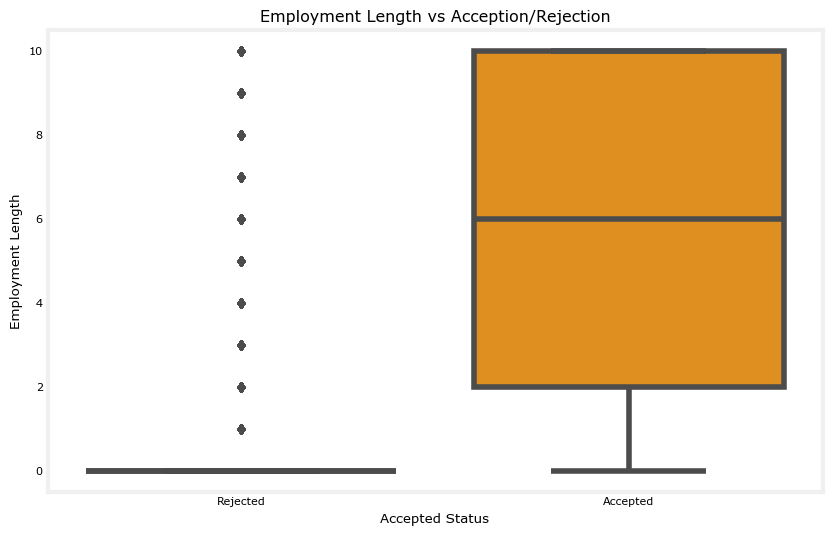

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='accepted',
            y='employment_length',
            data=df_accepted_rejected_cleaned)
plt.title('Employment Length vs Acception/Rejection')
plt.xlabel('Accepted Status')
plt.ylabel('Employment Length')
plt.xticks([0, 1], ['Rejected', 'Accepted'])
plt.show()

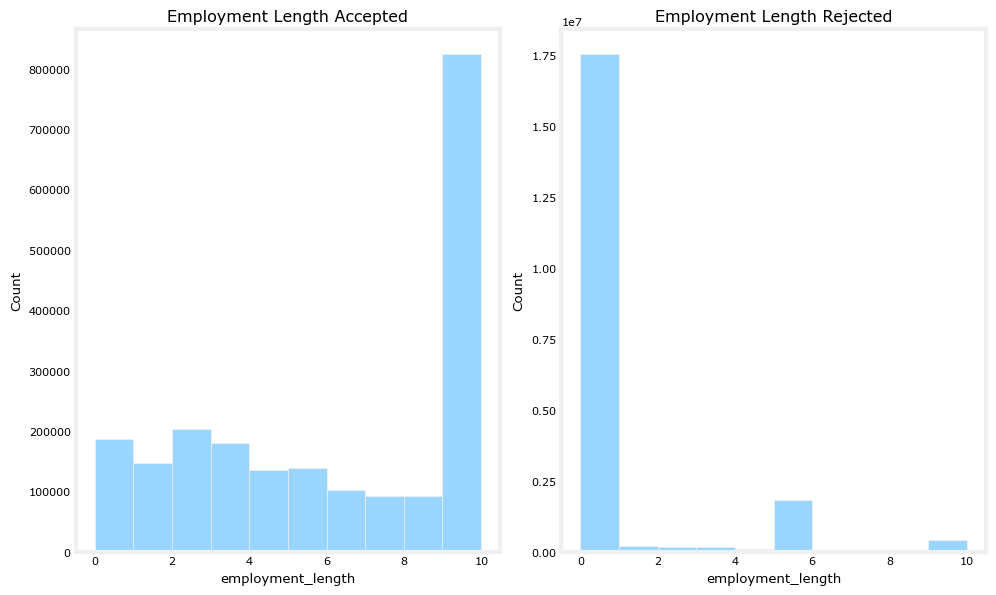

In [15]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Employment Length Accepted')
sns.histplot(df_accepted_rejected_cleaned[
    df_accepted_rejected_cleaned['accepted'] == 1],
             x='employment_length',
             bins=10,
             alpha=0.4)
plt.subplot(1, 2, 2)
plt.title('Employment Length Rejected')
sns.histplot(df_accepted_rejected_cleaned[
    df_accepted_rejected_cleaned['accepted'] == 0],
             x='employment_length',
             bins=10,
             alpha=0.4)
plt.tight_layout()
plt.show()

- Looking at the distributions of employment length for rejected vs. accepted, we observe a clear trend where people who's loans got rejected tended to have a lower mean and median employment length compared to those who got accepted. That being said, we do observe a few outliers in the rejected column that had significantly higher lengths of employment. The range for acceptance is much larger compared to the very narrow range for rejection.

**Do certain states tend get rejected/accepted more often?**

In [14]:
proportion_accepted_per_state = df_accepted_rejected_cleaned.groupby(
    'state')['accepted'].mean().reset_index()

volume_per_state = df_accepted_rejected_cleaned.groupby(
    'state').size().reset_index(name='loan_volume')

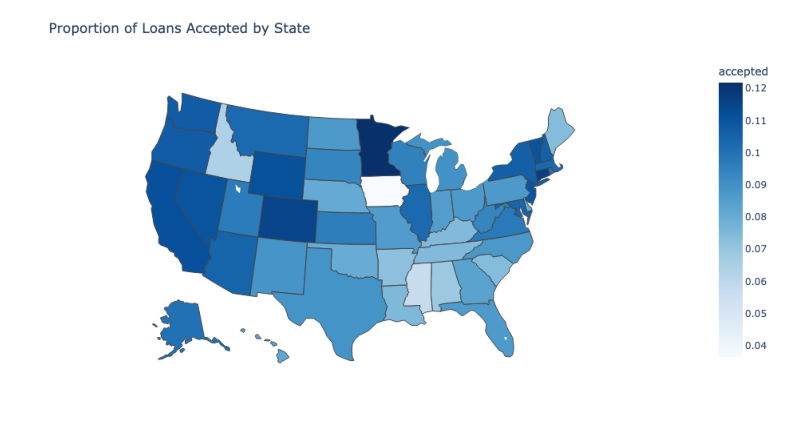

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
im = img.imread('images/newplot.png')
ax.imshow(im)
hide_spines(ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

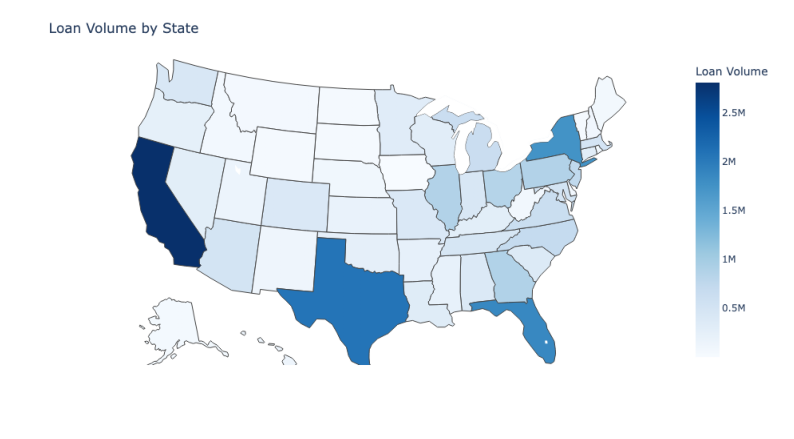

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
im = img.imread('images/newplot (1).png')
ax.imshow(im)
hide_spines(ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

- To understand the relationship between states and loan acceptance or rejection, we decided to plot two maps. Our first map represents loan volume per state. It is clear that large states that contain major cities like California, New York, Texas, and Florida contain a large volume of loan applicants compared to other smaller states. Our next map represents the loan acceptance rate per state, calculated by taking the proportion of accepted loans in each state. We observe a similar trend here, where loan acceptance rates tend to be higher in states with major cities. That being said, there are a few exceptions, like states like Oregon, Washington, Wyoming, etc., that maintained a high acceptance rate.

**Converting Zip Codes Into City**

In [33]:
# Json to convert zip codes to cities
f = open('lending_club_data/threeDigitZipCodes.json')
zips_mapping = json.load(f)

In [34]:
zip_to_city = {}
for v in zips_mapping.values():
    zip_to_city[v['id']] = v['city']

In [207]:
with open('zip_cod_mapping.json','w') as f:
    json.dump(zip_to_city,f)

In [36]:
df_accepted_rejected_cleaned['city'] = df_accepted_rejected_cleaned[
    'zip_code'].map(zip_to_city)

In [25]:
acceptance_per_city = df_accepted_rejected_cleaned.groupby(
    'city')['accepted'].mean().reset_index()

In [38]:
df_accepted_rejected_cleaned.head()

,loan_amnt,purpose,dti,addr_state,zip_code,emp_length,average_fico_score,accepted,city
0,3600.0,debt_consolidation,5.910000,PA,190,10.0,677.0,1,Philadelphia
1,24700.0,small_business,16.059999,SD,577,10.0,717.0,1,Rapid City
2,20000.0,home_improvement,10.780000,IL,605,10.0,697.0,1,Chicago
3,35000.0,debt_consolidation,17.059999,NJ,076,10.0,787.0,1,Hackensack
4,10400.0,major_purchase,25.370001,PA,174,3.0,697.0,1,York


In [39]:
# Verifying the cities match the states
df_accepted_rejected_cleaned[['addr_state', 'city']].head()

,addr_state,city
0,PA,Philadelphia
1,SD,Rapid City
2,IL,Chicago
3,NJ,Hackensack
4,PA,York


- We utilized some external data sources in order to collect the name of the city that corresponds to each zip code. The idea was that city name could possibly capture more of a general overview of borrowers while zip code can get a more detailed approach. Visualizing the zip codes and city names by volume/acceptance rate was a bit complicated, therefore we will be utilizing statistical test and mutual information to further understand the relationship between these geographical features and our target.

**Loan Purpose**

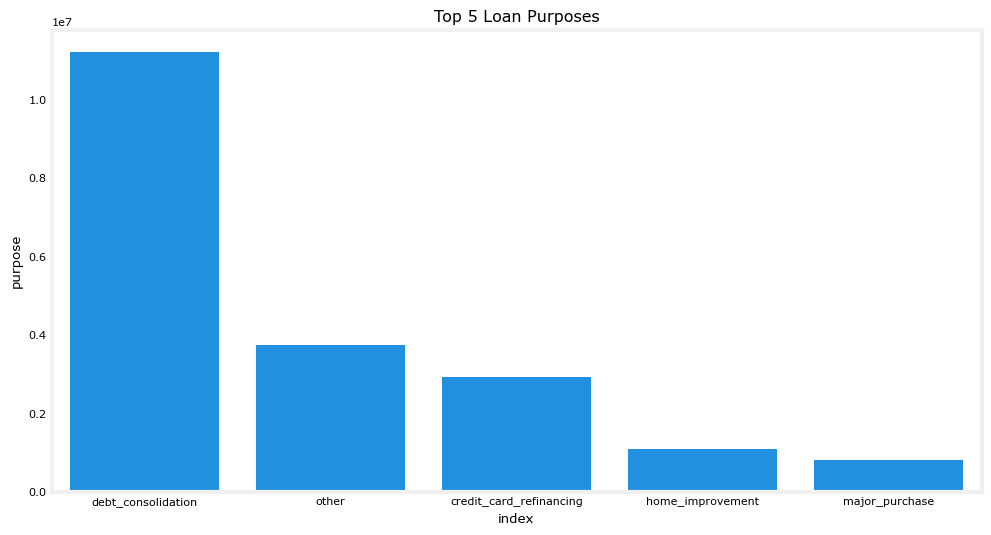

In [79]:
plt.figure(figsize=(12, 6))
plt.title('Top 5 Loan Purposes')
sns.barplot(df_accepted_rejected_cleaned['purpose'].value_counts().head().
            reset_index(),
            x='index',
            y='purpose',
            color=default_blue)
plt.show()

- Our bar plot displays the top 5 most common loan purposes. We observe that debt consolidation is the largest, followed by other and credit card refinancing. During our cleaning process we observed that there is many unique values for loan purpose. After we split our data, we be utilizing clustering in order to bin these categories into more distinct groups our model can learn from.

**Correlation**

In [40]:
df_accepted_rejected_corr = df_accepted_rejected_cleaned.dropna()

In [41]:
numerical_cols = df_accepted_rejected_corr.select_dtypes(
    exclude='object').columns[:-1]

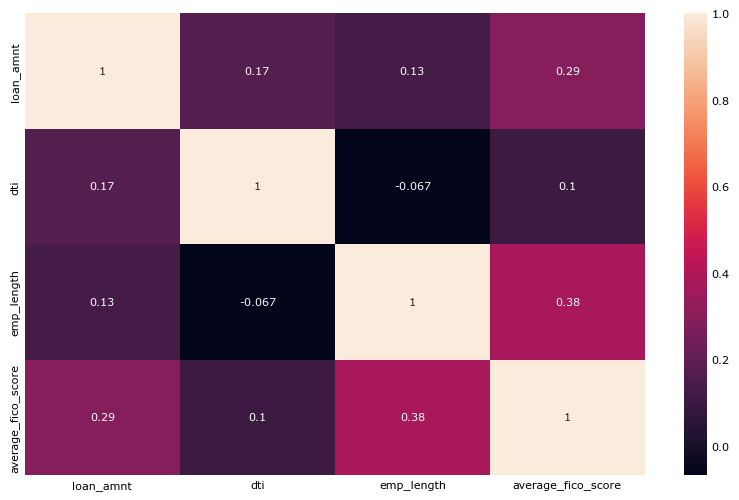

In [43]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_accepted_rejected_corr[numerical_cols].corr(numeric_only=True),
            annot=True)
plt.show()

In [44]:
for col in numerical_cols:
    correlation, p_value = pointbiserialr(
        df_accepted_rejected_corr[col], df_accepted_rejected_corr['accepted'])
    print(
        f"Correlation between {col} and acceptance: {correlation}, P-value: {p_value:.4f}"
    )

Correlation between loan_amnt and acceptance: 0.10425820752329805, P-value: 0.0000
Correlation between dti and acceptance: -0.06598110435744982, P-value: 0.0000
Correlation between emp_length and acceptance: 0.6678147297723749, P-value: 0.0000
Correlation between average_fico_score and acceptance: 0.4284419069063104, P-value: 0.0000


In [45]:
df_accepted_rejected_cleaned.head()

,loan_amnt,purpose,dti,addr_state,zip_code,emp_length,average_fico_score,accepted,city
0,3600.0,debt_consolidation,5.910000,PA,190,10.0,677.0,1,Philadelphia
1,24700.0,small_business,16.059999,SD,577,10.0,717.0,1,Rapid City
2,20000.0,home_improvement,10.780000,IL,605,10.0,697.0,1,Chicago
3,35000.0,debt_consolidation,17.059999,NJ,076,10.0,787.0,1,Hackensack
4,10400.0,major_purchase,25.370001,PA,174,3.0,697.0,1,York


- For our correlation matrix we utilized pearsons correlation in order to measure the relationships between our numerical variables. We observe that features such as amount requested has mild positive correlation with credit score, employment length and debt to income ratio. Employment length also is correlated with credit score. This does make sense since all these features can have an impact on another (employment length and credit scores, etc.).

- Following, we utilized pointbiserial correlation in order to measure correlation values of our numerical values vs our target variable(binary). Employment length has the strongest correlation with a value of 0.6 followed by credit score with a value of 0.42. Amount requested and debt to income ratio display much smaller values. Our p-values for all are close to 0, this is due to the fact that our dataset is very large and any small differences are deemed 'significant'.

**Data Splitting & Baseline Model**

In [46]:
df_accepted_rejected_cleaned.shape

(23541126, 9)

In [47]:
df_accepted_rejected_cleaned = df_accepted_rejected_cleaned.dropna(
    subset=['city', 'zip_code'])

In [48]:
X = df_accepted_rejected_cleaned.drop(columns=['accepted'])
y = df_accepted_rejected_cleaned['accepted']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.05,
                                                    stratify=y,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.05 / (1 - 0.05),
                                                  stratify=y_train,
                                                  random_state=42)

In [49]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(21187010, 8)
(1177057, 8)
(1177057, 8)


In [24]:
print('Training Class Distribution')
print(y_train.value_counts() / y_train.shape * 100)
print('--------------------')
print('Evaluation Class Distribution')
print(y_val.value_counts() / y_val.shape * 100)
print('--------------------')
print('Testing Class Distribution')
print(y_test.value_counts() / y_test.shape * 100)

Training Class Distribution
0    90.469939
1     9.530061
Name: accepted, dtype: float64
--------------------
Evaluation Class Distribution
0    90.46996
1     9.53004
Name: accepted, dtype: float64
--------------------
Testing Class Distribution
0    90.46996
1     9.53004
Name: accepted, dtype: float64


In [25]:
dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_val)
print(classification_report(y_val, dummy_preds))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90   1064883
           1       0.10      0.10      0.10    112174

    accuracy                           0.83   1177057
   macro avg       0.50      0.50      0.50   1177057
weighted avg       0.83      0.83      0.83   1177057



- After splitting our data into train,evaluation, and testing, we have established a baseline model in order to gain an understanding of how our model would perform by simply randomly guessing. As we can see the model performs very well on predicting rejected loans (due to the high imbalance), but very poorly for predicting accepted loans. Due to imbalance of classes, accuracy would not be the best metric. So, we have decided to focus on precision because in our case the cost of a false positives (predicting a loan is accepted but its actually rejected) is higher than the cost of false negatives. From a business standpoint this also make sense given the fact that there is more risk and incorrectly identifying a rejected loan to be accepted, then vice-versa.

**Clustering Our Text Data**

In [55]:
df_accepted_rejected_cleaned['purpose'].nunique()

43790

In [56]:
# Impute missing values with other for clustering prep
data_splits = [X_train, X_test, X_val]
for df in data_splits:
    df['purpose'] = df['purpose'].fillna('other').apply(preprocess_text)

In [58]:
tfidf_transformed, tfidf_model = apply_tfidf_vectorizer(
    X_train['purpose'], X_test['purpose'], X_val['purpose'])

In [60]:
cluster_results, mini_kmeans_model = apply_minibatch_kmeans(*tfidf_transformed,
                                                            n_clusters=12)

train_clusters, test_clusters, val_clusters = cluster_results

In [61]:
X_train['purpose_cluster'] = train_clusters
X_test['purpose_cluster'] = test_clusters
X_val['purpose_cluster'] = val_clusters

In [62]:
X_train[X_train['purpose_cluster'] == 0].head()

,loan_amnt,purpose,dti,addr_state,zip_code,emp_length,average_fico_score,city,purpose_cluster
21787310,20000.0,debt consolidation,14.580000,TN,376,0.0,NaN,Johnson City,0
27503916,20000.0,debt consolidation,30.299999,TX,797,0.0,731.0,Midland,0
28910418,25300.0,debt consolidation,47.490002,WI,545,0.0,NaN,Rhinelander,0
5334337,9000.0,debt consolidation,0.270000,WA,993,0.0,657.0,Pasco,0
2880153,35000.0,debt consolidation,34.049999,CA,958,0.0,672.0,Sacramento,0


In [77]:
for df in data_splits:
    df.drop(columns=['purpose'], inplace=True)

In [78]:
dump(mini_kmeans_model, 'minibatch_kmeans_model.joblib')
dump(tfidf_model, 'tfidf_model.joblib')

['tfidf_model.joblib']

- During our initial exploration of our purpose column we discovered a few things. First, we investigated the lending club website, which, displayed 12 distinct categories for loan purpose. Many of those aligned with the loan purposes in our dataset (debt consolidation,business, etc.), but there was many different variations and different spellings as well. We utilized MiniBatchKmeans(due to the size of our dataset) algorithm in order to cluster the loan purposes into 12 distinct groups for our model to learn from. From initial investigation, we can see that the clustering performed pretty well at categorizing the text data.

**Hypothesis Testing**

**Is there a significant association between our categorical features and the acceptance/rejection of a loan?**

**Null Hypothesis** : There is no association between a specific categorical feature (e.g., ) and the acceptation/rejection of loan.  
**Alternative Hypothesis**: There is an association between a specific categorical feature and the acceptation/rejection of loan.

In [79]:
alpha = 0.05 / 5
alpha

0.01

In [81]:
multiple_test_chi2(
    X_train[[
        'city', 'addr_state', 'zip_code', 'purpose_cluster', 'emp_length'
    ]], y_train)

{'city': [0.0, 82377.31086803215],
 'addr_state': [0.0, 43961.68024548423],
 'zip_code': [0.0, 99385.52725756765],
 'purpose_cluster': [0.0, 434217.790707684],
 'emp_length': [0.0, 9571934.622091077]}

**Is there a significant difference in the distribution of our numerical features and the acceptance/rejection of a loan?**

**Null Hypothesis**:There is no difference in the distribution of a specific numerical feature (e.g., age) between individuals who have had a stroke and those who have not.  
**Alternative Hypothesis**: There is a difference in the distribution of a specific numerical feature (e.g., age) between individuals who have had a stroke and those who have not.

In [58]:
alpha = 0.05 / 3
alpha

0.016666666666666666

In [82]:
mutiple_test_mann_whitney(
    X_train[['loan_amnt', 'dti', 'average_fico_score']],
    y_train,
)

{'loan_amnt': [0.0, 14872679793531.5],
 'dti': [0.0, 20036185177769.0],
 'average_fico_score': [0.0, 2246771211779.0]}

- We performed multiple Chi-Square tests to see if there is an association between our categorical features and the acceptance/rejection of a loan. We utilized bonferroni correction to create our alpha (0.01), which takes into to account the multiple hypothesis test being performed. The resulting dictionary displays the corresponding p-values for each feature. All our p-values are close to 0, indicating that there is statistical significance between these variables and our target. That being said, as we discussed earlier, this has to be taken with grain of salt, due to volume of data we have, any small change would be deemed significant.


- We followed a similar approach for our numerical variables, using a  Mann–Whitney U test. We utilized a non parametric test, due to our data not following a normal distribution which is an assumption when using a test like a t-test. The results were also p-values close approaching 0. Following, we will be using mutual information which might be a better approach to understanding the relationships between our features and target.

**Mutual Information**

In [140]:
numerical_cols, cat_cols = get_numerical_categorical_columns(X_train)

In [145]:
# Assinging purpose cluster as a categorical column
numerical_cols = list(numerical_cols[:-1])
cat_cols = list(cat_cols) + ['purpose_cluster']

In [88]:
preprocessor_mi = create_preprocessor(numerical_cols, cat_cols,
                                      SimpleImputer(strategy='mean'),
                                      'passthrough', TargetEncoder())
sample_size = 100_000
X_train_sample = X_train[numerical_cols + cat_cols].sample(n=sample_size,
                                                           random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
mi_scores = mutual_information_scores(X_train_sample, y_train_sample,
                                      preprocessor_mi)

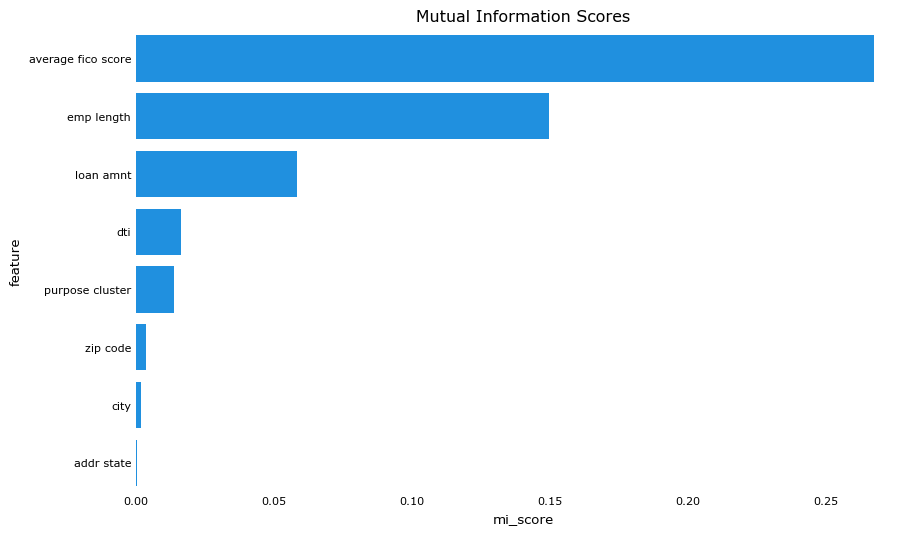

In [92]:
plt.figure(figsize=(10, 6))
plt.title('Mutual Information Scores')
fig = sns.barplot(mi_scores,
                  y='feature',
                  x='mi_score',
                  color=default_blue,
                  orient='horizontal')
hide_spines(fig)
plt.show()

- Our plot above displays the mutual information scores of our features vs our target. We used a subset of our data due to the fact that computing mi scores can be computationally expensive. Credit score and employment length have the highest scores, indicating that their is a strong dependence between those features and our target. Amount requested, debt to income ratio, and purpose cluster display mild relationships, while the geographical data displayed the lowest scores.

**Model Selection**


In [30]:
models = {
    'XGBoost':
    xgboost.XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          eval_metric='logloss',
                          n_estimators=150,
                          max_depth=2,
                          verbosity=2),
    'RandomForest':
    RandomForestClassifier(random_state=42,
                           n_estimators=150,
                           max_depth=2,
                           class_weight='balanced'),
    'LinearSVM':
    SGDClassifier(random_state=42,
                  loss='hinge',
                  class_weight='balanced',
                  penalty='l2'),
    'LogisticRegression':
    LogisticRegression(
        random_state=42,
        class_weight='balanced',
    )
}

In [103]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
encoder = TargetEncoder()
preprocessor_linear = create_preprocessor(numerical_cols, cat_cols, imputer,
                                          scaler, encoder)
preprocessor_tree_based = create_preprocessor(numerical_cols, cat_cols,
                                              imputer, 'passthrough', encoder)

In [49]:
model_results = {}
for model_name, model in tqdm(models.items()):
    if model_name in ['LogisticRegression', 'LinearSVM']:
        pipeline = create_pipeline(model,
                                   preprocessor_linear,
                                   feature_selection=None)
    else:
        pipeline = create_pipeline(model,
                                   preprocessor_tree_based,
                                   feature_selection=None)
    pipeline.fit(X_train, y_train)
    y_preds = pipeline.predict(X_val)
    model_results[model_name] = [
        precision_score(y_val, y_preds, pos_label=1),
        recall_score(y_val, y_preds, pos_label=1)
    ]

100%|████████████████████████████████████████████| 4/4 [40:56<00:00, 614.01s/it]


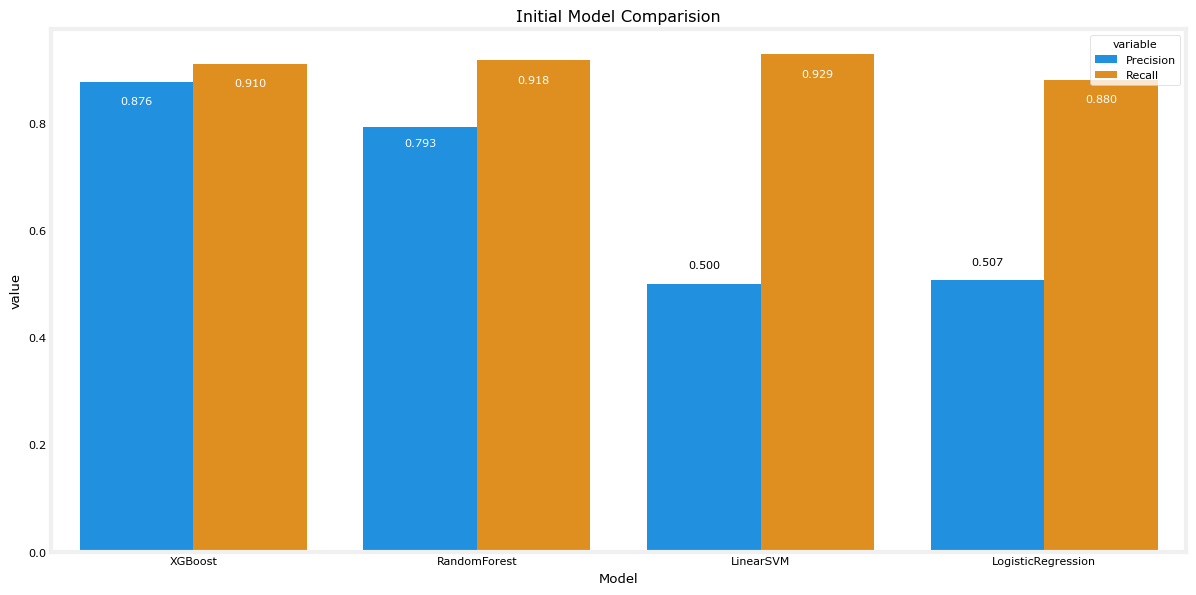

In [76]:
results_df = pd.DataFrame(model_results, index=[
    'Precision', 'Recall'
]).T.reset_index().rename(columns={'index': 'Model'})
plt.figure(figsize=(12, 6))
plt.title('Initial Model Comparision')
fig = sns.barplot(results_df.melt(value_vars=['Precision', 'Recall'],
                                  id_vars='Model'),
                  x='Model',
                  y='value',
                  hue='variable')
annotate_bars(fig)
plt.tight_layout()

- For our model preprocessing we created one for tree based models (no scaling) and one for linear models (scaling). Since some of our columns contained missing values (mostly the numerical columns) we utilized a simple imputer. Ideally we would like to use something like KNN or iterative imputer, but due to the size and time constraints,those methods were simply not feasible. We used median, due to the nature of financial data where you have outliers that can skew the mean. We also tried imputing with zeros, but the results were ever slightly better with median imputation. For our categorical variables we used target encoding, this made sense as some of our columns had very high cardinality and represented geographical data, which target encoding can capture.

- Due to the size of our dataset, we decided to test a few different types of models without much tuning (boosting,bagging,linear) in order to understand which models might be performing best for our dataset. As we can we see from our plot above, XGBoost performed the best achieving a precision (class 1) of around 88% and recall of 91%. Random Forest performed slightly worse, but still achieved good results (80% precision and 91% recall). Our linear models did not perform as well in terms of precision.

- Moving forward, we will be using our XGBoost model, as we can see we got pretty great results without even properly tuning. We will be using optuna in order to try to maximize our results from our XGBoost model.

**Hyperparameter Tuning & Model Evaluation (XGBoost)**

In [32]:
X_train_preprocessed = preprocessor_tree_based.fit_transform(X_train, y_train)
X_val_preprocessed = preprocessor_tree_based.transform(X_val)

In [34]:
objective = get_objective_xgb_binary(X_train_preprocessed,
                                          X_val_preprocessed, y_train, y_val,average_precision_score)

In [41]:
optuna.logging.get_logger("optuna").setLevel(logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=75)

In [38]:
best_params = {
    param_name.replace('xgb_', ''): value
    for param_name, value in study.best_params.items()
}

In [43]:
best_params

{'n_estimators': 321,
 'learning_rate': 0.12769801243261328,
 'max_depth': 3,
 'scale_pos_weight': 1.361537960909387,
 'min_child_weight': 3,
 'subsample': 0.9887066726461433,
 'colsample_bytree': 0.5178873764720207,
 'lambda': 0.009973511501566924}

In [155]:
best_params = {
    'n_estimators': 321,
    'learning_rate': 0.12769801243261328,
    'max_depth': 3,
    'scale_pos_weight': 1.361537960909387,
    'min_child_weight': 3,
    'subsample': 0.9887066726461433,
    'colsample_bytree': 0.5178873764720207,
    'lambda': 0.009973511501566924,
    'random_state': 42
}

In [95]:
xgb_pipeline = create_pipeline(xgboost.XGBClassifier(**best_params),
                               preprocessor_tree_based)
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['loan_amnt', 'dti',
                                                   'emp_length',
                                                   'average_fico_score']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   'passthrough'),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['addr_state', 'zip_code',
                                                   'city',
                                                   'purpose_cluster'])])),
                ('clas...
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.009973511501566924,
                               learning_rate=0.12769801243261328, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=321, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [100]:
y_preds = xgb_pipeline.predict(X_val)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1064883
           1       0.87      0.93      0.90    112174

    accuracy                           0.98   1177057
   macro avg       0.93      0.96      0.94   1177057
weighted avg       0.98      0.98      0.98   1177057



In [101]:
xgb_ft_importances_tuned = extract_feature_importances(xgb_pipeline)
xgb_ft_importances_tuned['feature'] = xgb_ft_importances_tuned[
    'feature'].str.replace("^__", "", regex=True)

In [102]:
xgb_ft_importances_tuned

,feature,importance
2,emp_length,0.483901
3,average_fico_score,0.409054
1,dti,0.044767
7,purpose_cluster,0.027934
0,loan_amnt,0.019768
5,zip_code,0.011296
6,city,0.002374
4,addr_state,0.000907


- After multiple iterations of hyperparameter tuning, we successfully found our optimal parameters. Given the significant imbalance in our dataset, we chose to focus on maximizing the PR-AUC, which will allow us to also do some threshold tuning l. The model is performing quite well all across the board. We achieved a macro precision of 93%. We also utilized the feature importances to identify features that are not contributing much. We can see city and state seem to be contributing very little. We will be removing those and evaluating again.

**Removing Features With Low Importance**

In [161]:
new_cat_cols = ['zip_code', 'purpose_cluster']
preprocessor_features_removed = create_preprocessor(numerical_cols,
                                                    new_cat_cols, imputer,
                                                    'passthrough', encoder)

In [162]:
xgb_pipeline_features_removed = create_pipeline(
    xgboost.XGBClassifier(**best_params), preprocessor_features_removed)

In [168]:
X_train_fts_removed = X_train.drop(columns=['addr_state','city'])

In [169]:
xgb_pipeline_features_removed.fit(X_train_fts_removed,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_amnt', 'dti',
                                                   'emp_length',
                                                   'average_fico_score']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   'passthrough'),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['zip_code',
                                                   'purpose_cluster'])])),
                ('classif...
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.009973511501566924,
                               learning_rate=0.12769801243261328, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=321, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [170]:
y_preds = xgb_pipeline_features_removed.predict(X_val)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99   1064883
           1       0.86      0.90      0.88    112174

    accuracy                           0.98   1177057
   macro avg       0.93      0.94      0.94   1177057
weighted avg       0.98      0.98      0.98   1177057



- After removing the city and state features, which showed very little importance, our model's performance actually dropped a slight bit in terms of recall and precision. Even though those features were deemed non-important, they still contributed a slight amount, so moving forward, we will be evaluating our model with all the features on our test set.

**Final Evaluation**

In [174]:
y_preds = xgb_pipeline.predict(X_test)
y_probas = xgb_pipeline.predict_proba(X_test)[:, -1]

In [177]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1064883
           1       0.87      0.93      0.90    112174

    accuracy                           0.98   1177057
   macro avg       0.93      0.96      0.94   1177057
weighted avg       0.98      0.98      0.98   1177057



In [175]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = roc_auc_score(y_test, y_probas)

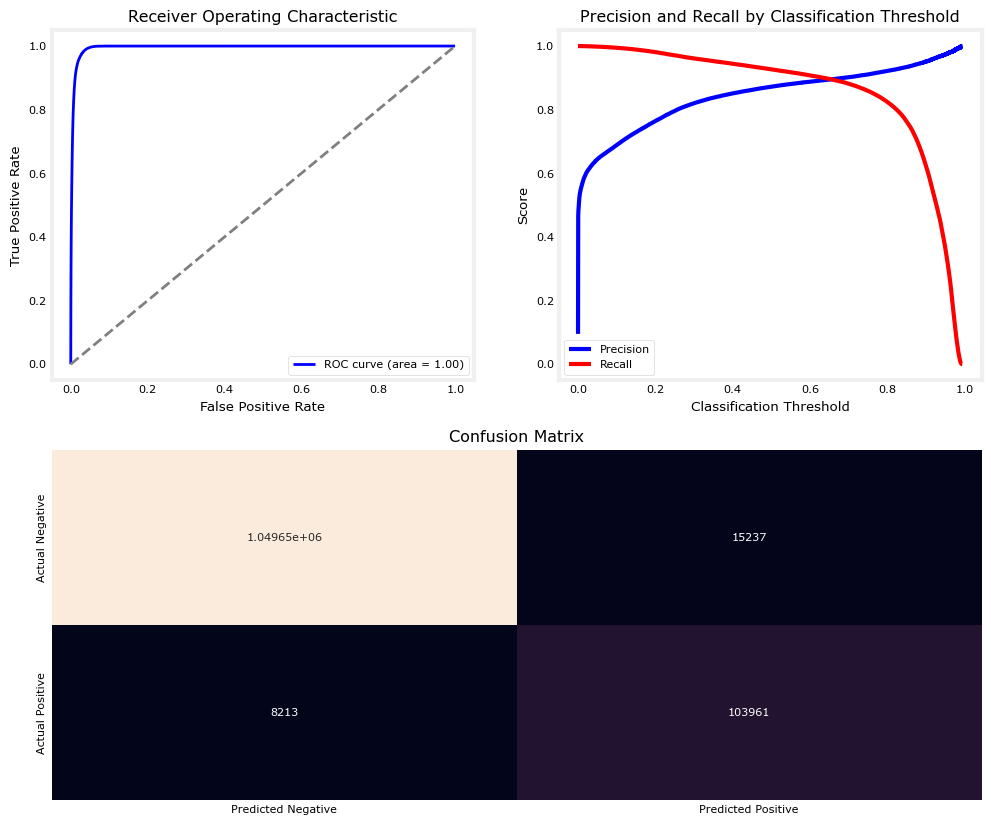

In [176]:
conf_matrix_rf = confusion_matrix_df(y_test, y_preds)
plot_model_evaluation(fpr, tpr, roc_auc, thresholds_pr, precision, recall,
                      conf_matrix_rf)

In [184]:
# Threshold tuning
y_preds = (y_probas >= 0.6).astype(int)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1064883
           1       0.89      0.91      0.90    112174

    accuracy                           0.98   1177057
   macro avg       0.94      0.95      0.94   1177057
weighted avg       0.98      0.98      0.98   1177057



- Our final evaluation on the test set displays almost identical results to our evaluation set, with a marco precision of 93%. We also did some threshold adjustment (0.6) where we can increase our precision a slight bit without losing much recall. The AUC is near perfect, indicating that our model is able to differentiate between the two classes almost perfectly. 

**SHAP Values**

In [185]:
# Sample X_test for shap values
X_test_sample, _, y_test_sample, _ = train_test_split(X_test,
                                                      y_test,
                                                      train_size=0.1,
                                                      random_state=42,
                                                      stratify=y_test)
X_test_sample_preprocessed = xgb_pipeline.named_steps[
    'preprocessor'].transform(X_test_sample)

In [199]:
explainer = shap.TreeExplainer(xgb_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_sample_preprocessed)

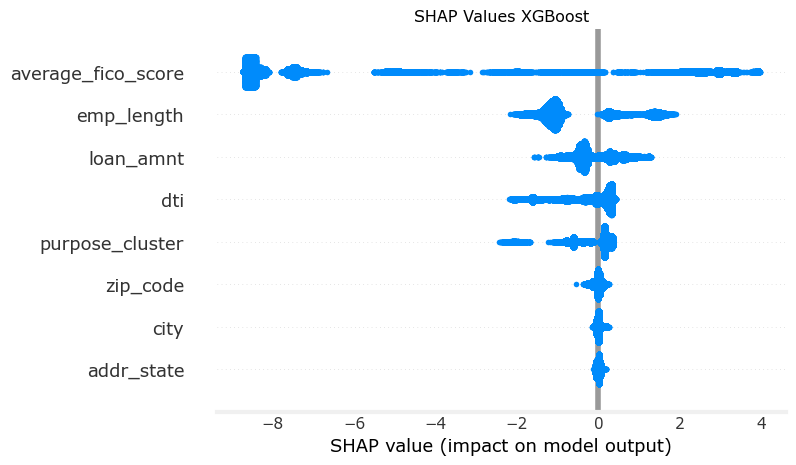

In [187]:
plt.title('SHAP Values XGBoost')
shap.summary_plot(shap_values, feature_names=numerical_cols + cat_cols)
plt.show()

- Following our final evaluation, we plotted SHAP values, which allow for some explanation of which variables were significant contributors to our model's performance. As we can see, credit score played the biggest role in predicting whether a loan was rejected or accepted, followed by employment length and the amount requested.

**Saving Our Final Model**

In [204]:
dump(xgb_pipeline, 'xgb_pipeline_accepted_rejected.joblib')

['xgb_pipeline_accepted_rejected.joblib']

**Conclusion**:  
Our initial exploratory analysis provided an understanding of the dataset at hand, identifying outliers such as extreme values in DTI and credit scores. Through visualization as well as mutual information/shap values, we gained an understanding of the variables that differentiate between accepted and rejected loan applications, revealing that factors like credit score, employment duration, debt-to-income ratio, and requested loan amount played a big role in determining loan outcomes. We experimented with multiple models to identify the most suitable one for our dataset and fine-tuned the hyperparameters to enhance our results. Given the business context, we prioritized precision as our key metric, acknowledging that false positives carry a greater cost for our operation than false negatives. Ultimately, our final model achieved an impressive macro precision of 94%, signifying a robust predictive capability.